In [1]:
import numpy as np

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import gym
from dezero import Model, optimizers
import dezero.functions as F
import dezero.layers as L
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
from common import utils


class Policy(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)
        # self.l3 = L.Linear(1)

    def forward(self, x):
        # x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x


class Agent1:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.trainer = optimizers.Adam(self.lr)
        self.trainer.setup(self.pi)

    def get_action(self, state):
        state = state.reshape(1, -1)
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]
        # if np.random.rand() < probs[0].data.item():
        #     action = 0
        #     action_prob = probs[0]
        # else:
        #     action = 1
        #     action_prob = 1 - probs[0]
        # return action, action_prob

    def add(self, reward, prob):
        self.memory.append((reward, prob))

    def update(self):
        self.pi.cleargrads()
        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G
            loss += -F.log(prob) * G
        loss.backward()
        self.trainer.update()
        self.memory = []


env = gym.make('CartPole-v1')
state, _ = env.reset()
agent = Agent1()
action, prob = agent.get_action(state)
print('action:', action)
print('prob:', prob)

G = 100.0
J = G * F.log(prob)
print('J:', J)

J.backward()

action: 1
prob: variable(0.48783435593259167)
J: variable(-71.77793653143023)


100%|██████████| 1/1 [00:00<00:00, 177.61it/s, total_reward=14]


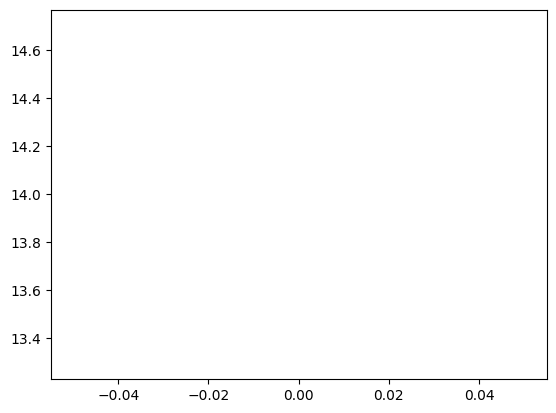

In [4]:
episodes = 1  # 3000
env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = Agent1()
reward_history = []

pbar = tqdm(total=episodes)
for episode in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)

        agent.add(reward, prob)
        state = next_state
        total_reward += reward
    agent.update()
    reward_history.append(total_reward)
    pbar.set_postfix({'total_reward': total_reward})
    pbar.update(1)
pbar.close()

plt.plot(reward_history)
plt.show()

Total Reward 10.0


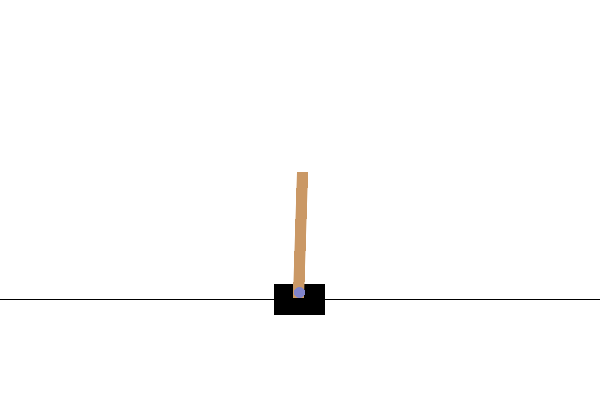

In [5]:
import imageio
from IPython.display import Image

frames = []
gif_path = "cartpole.gif"

state, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = agent.get_action(state)
    next_state, reward, done, _, _ = env.step(action)
    state = next_state
    total_reward += reward
    frames.append(env.render())
print('Total Reward', total_reward)
imageio.mimsave(gif_path, frames, fps=30)
Image(filename=gif_path)

In [6]:
x = np.array([90, 40, 50])
avg = np.array([82, 46, 49])
diff = x - avg
print(np.var(diff))

32.666666666666664


In [3]:
class PolicyNet(Model):
    def __init__(self, action_size=2):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)
        # self.l3 = L.Linear(1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x


class ValueNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        return self.l2(x)


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0002
        self.lr_v = 0.0005
        self.action_size = 2

        self.pi = PolicyNet()
        self.v = ValueNet()
        self.optimizer_pi = optimizers.Adam(self.lr_pi).setup(self.pi)
        self.optimizer_v = optimizers.Adam(self.lr_v).setup(self.v)

    def get_action(self, state, is_greedy=False):
        state = state.reshape(1, -1)
        probs = self.pi(state)
        probs = probs[0]
        
        if is_greedy:
            # action = 0 if probs[0].data.item() > 0.5 else 1
            action = probs.data.argmax().item()
            return action, None

        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]
        
        # if np.random.rand() < probs[0].data.item():
        #     action = 0
        #     action_prob = probs[0]
        # else:
        #     action = 1
        #     action_prob = 1 - probs[0]
        # return action, action_prob

    def update(self, state, action_prob, reward, next_state, done):
        state = state.reshape(1, -1)
        next_state = next_state.reshape(1, -1)

        target = reward + self.gamma * self.v(next_state) * (1 - done)
        target.unchain()
        v = self.v(state)
        loss_v = F.mean_squared_error(v, target)

        delta = target - v
        delta.unchain()
        loss_pi = -F.log(action_prob) * delta
        self.v.cleargrads()
        self.pi.cleargrads()
        loss_v.backward()
        loss_pi.backward()
        self.optimizer_v.update()
        self.optimizer_pi.update()

 23%|██▎       | 697/3000 [00:30<01:42, 22.49it/s, total_reward=670]


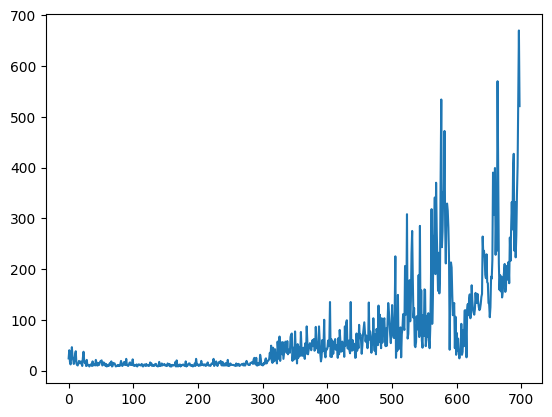

In [10]:
episodes = 3000 # 3000
env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = Agent()
reward_history = []

pbar = tqdm(total=episodes)
for episode in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.update(state, prob, reward, next_state, done)
        state = next_state
        total_reward += reward
    reward_history.append(total_reward)
    if (np.array(reward_history[-4:]) > 500).sum().item() >= 3:
        break
    pbar.set_postfix({'total_reward': total_reward})
    pbar.update(1)
pbar.close()

plt.plot(reward_history)
plt.show()

agent.pi.save_weights('policy_weight.npz')
agent.v.save_weights('value_weight.npz')

532.0
Total Reward 532.0


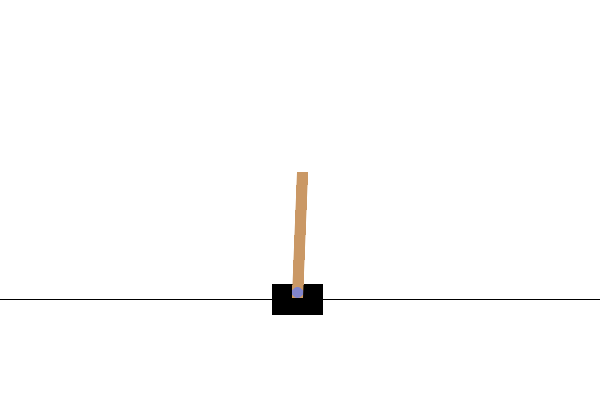

In [6]:
frames = []
gif_path = "cartpole.gif"

env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = Agent()

agent.pi.load_weights('policy_weight.npz')
agent.v.load_weights('value_weight.npz')

reward_history = []
for _ in range(1):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = agent.get_action(state,is_greedy=True)
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        total_reward += reward
        if total_reward > 1000: # 7000
            break
        frames.append(env.render())
    reward_history.append(total_reward)
print(np.mean(reward_history))
print('Total Reward', total_reward)
imageio.mimsave(gif_path, frames, fps=30)
Image(filename=gif_path)